In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
from nltk import FreqDist
from wordcloud import WordCloud
df = pd.read_csv('imdb-reviews_2.csv')
df.head()


[nltk_data] Downloading package punkt to C:\Users\Prashant
[nltk_data]     Mourya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Prashant Mourya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,review,label
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [2]:
# Review Frquency Count
vc_df = pd.DataFrame(df['label'].value_counts()).reset_index()
vc_df.columns = ['Sentiment', 'Count'] 
vc_df['Sentiment'] = vc_df['Sentiment'].map({1 : 'Positive', 0: 'Negative'}) 
vc_df

,Sentiment,Count
0,Positive,2528
1,Negative,2472


In [3]:
# Replacing punctuations with space
df['review_processed'] = df['review'].str.replace("[^a-zA-Z#]", " ") 


# Re ordering columns
df = df[['review','review_processed','label']]
df.head()

,review,review_processed,label
0,"first think another Disney movie, might good, ...",first think another Disney movie might good ...,1
1,"Put aside Dr. House repeat missed, Desperate H...",Put aside Dr House repeat missed Desperate H...,0
2,"big fan Stephen King's work, film made even gr...",big fan Stephen King s work film made even gr...,1
3,watched horrid thing TV. Needless say one movi...,watched horrid thing TV Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,truly enjoyed film acting terrific plot Jeff...,1


In [4]:
# Replacing short words
df['review_processed'] = df['review_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [5]:
# make entire text lowercase
df['review_processed'] = [review.lower() for review in df['review_processed']]

In [6]:
# Removing Stopwords Begin

stop_words = stopwords.words('english')


# Making custom list of words to be removed 
add_words = ['movie','film','one','make','even']

# Adding to the list of words
stop_words.extend(add_words)

# Function to remove stop words 
def remove_stopwords(rev):
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

# Removing stopwords
df['review_processed'] = [remove_stopwords(r) for r in df['review_processed']]

In [7]:
# Begin Lemmatization 

# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df['review_processed'] = df['review_processed'].apply(lambda x: lemmatize_sentence(x))
df.head()

,review,review_processed,label
0,"first think another Disney movie, might good, ...",first think another disney might good kid watc...,1
1,"Put aside Dr. House repeat missed, Desperate H...",put aside house repeat miss desperate housewif...,0
2,"big fan Stephen King's work, film made even gr...",big fan stephen king work make great fan king ...,1
3,watched horrid thing TV. Needless say one movi...,watch horrid thing needless say movie watch se...,0
4,truly enjoyed film. acting terrific plot. Jeff...,truly enjoyed act terrific plot jeff combs tal...,1


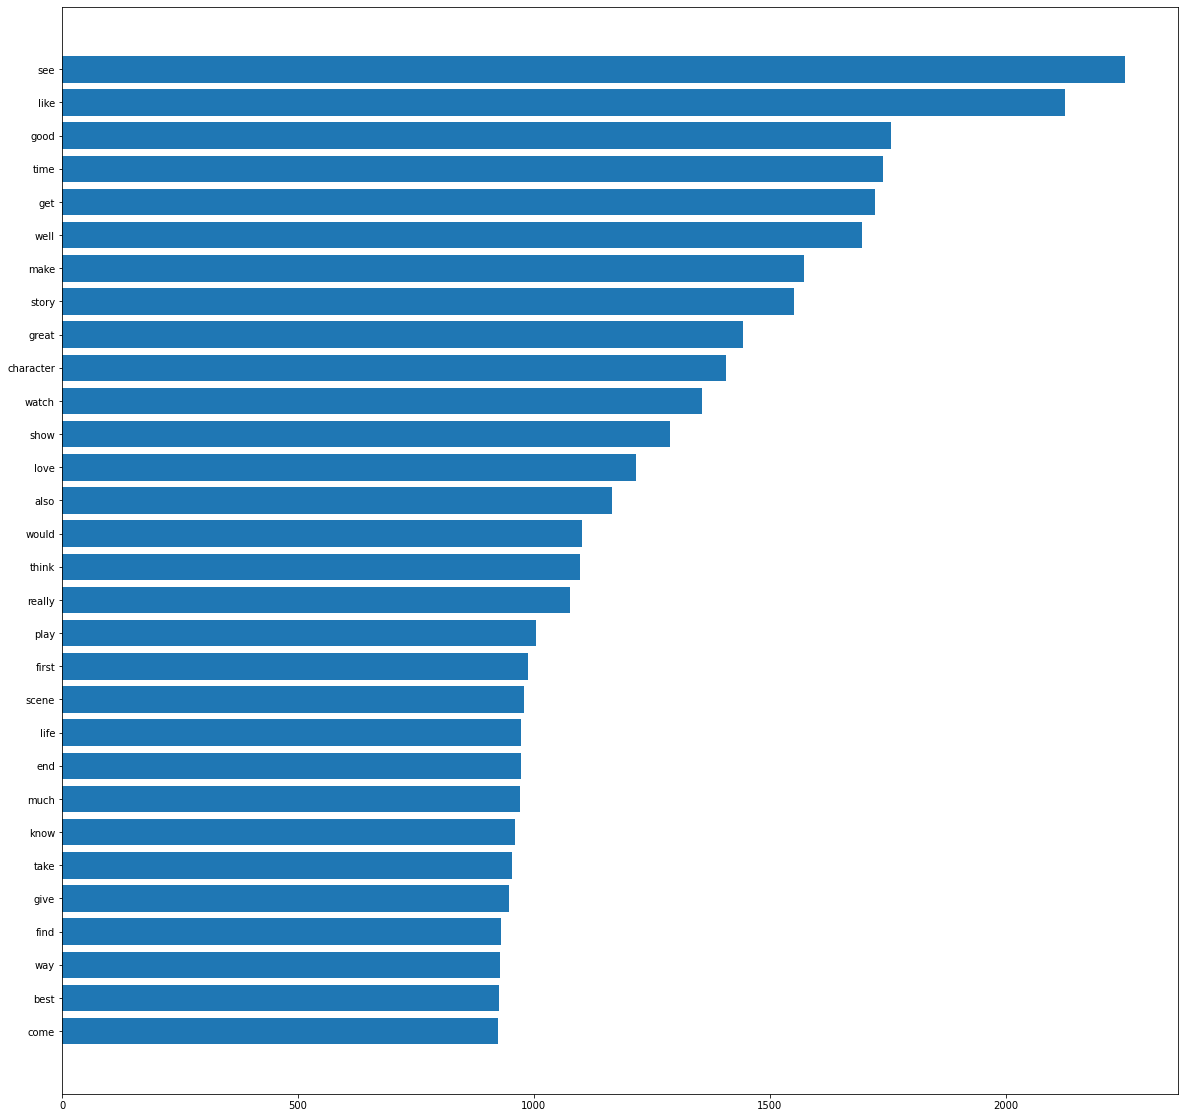

In [8]:
# Plotting most frequent words from positive reviews using bar chart


# Subset positive review dataset
all_words_df = df[df['label'] == 1]

# Extracts words into list and count frequency
all_words = ' '.join([text for text in all_words_df ['review_processed']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})

# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 30) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,20))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

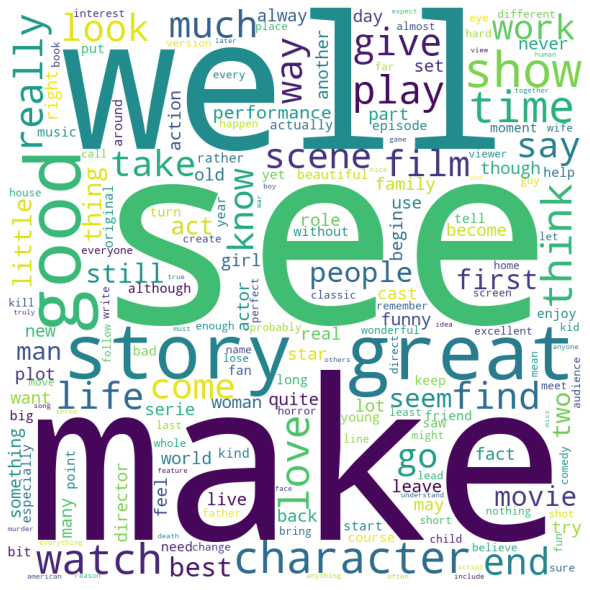

In [9]:
# Bilding a Word Cloud
word_cloud_df = df[df['label'] == 1]
all_words = ' '.join([text for text in word_cloud_df['review_processed']])
 

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [10]:
# Importing module
from sklearn.feature_extraction.text import CountVectorizer

# Creating sparse matrix of top 2500 tokens
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(df.review_processed).toarray()
y = df.label.values

# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [11]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Testing the model on test set
y_pred = classifier.predict(X_test)

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("The model accuracy is", accuracy )

[[416 101]
 [176 307]]
The model accuracy is 0.723


              precision    recall  f1-score   support

           0       0.70      0.80      0.75       517
           1       0.75      0.64      0.69       483

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.72      1000
weighted avg       0.73      0.72      0.72      1000



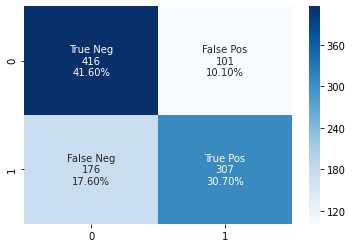

In [13]:
# Creating the confusion matrix and classification report
# Using Seaborn heatmap to show TP, FP, TN, FN values

from sklearn.metrics import classification_report

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

print(classification_report(y_test, y_pred))

In [14]:
# Using  logistic regression model and check the accuracy of the model for C=0.01,0.05, 0.5,and 1.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(solver='liblinear',C=0.01,  random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("The model accuracy is", accuracy )

The model accuracy is 0.845


In [15]:
model = LogisticRegression(solver='liblinear',C=0.05,  random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("The model accuracy is", accuracy )

The model accuracy is 0.849


In [16]:
model = LogisticRegression(solver='liblinear',C=0.5,  random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("The model accuracy is", accuracy )

The model accuracy is 0.835


In [17]:
model = LogisticRegression(solver='liblinear',C=1,  random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("The model accuracy is", accuracy )

The model accuracy is 0.827


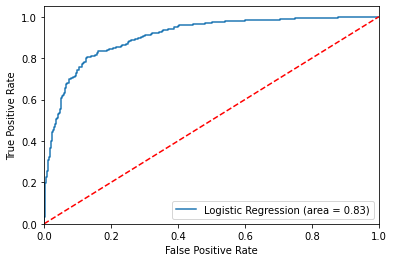

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Area under the curve is 0.83